In [ ]:
import pandas as pd

# 유방암 데이터셋 가져오기
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

In [ ]:
### 레이블 인코더 클래스로 데이터셋의 클래스를 정수로 변환
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)

le.transform(['M', 'B'])


array([1, 0])

In [12]:
### 파이프라인을 이용해서 데이터 스케일링, 데이터셋 압축, 학습, 추론까지 한번에 할 수 있게 만들기

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 일단 데이터셋을 나누고
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# 전처리->학습->추론 파이프라인 만들어주기
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='liblinear', random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


In [23]:
### k겹 교차검증과 모델 성능 평가

import numpy as np
from sklearn.model_selection import StratifiedKFold

# k겹 교차검증 클래스의 인자(n_splits)로 몇개로 쪼개서 검증할 것인가 정할 수 있음.
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []

for k, (train, test) in enumerate(kfold):
    
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1, np.bincount(y_train[train]), score))
    


폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956


In [ ]:
### cross_val_score 클래스를 사용하면 그냥 바로 k겹 교차검증을 할 수 있음.

from sklearn.model_selection import cross_val_score


scores = cross_val_score(estimator=pipe_lr,
                         X=X_train, y=y_train, cv=10, n_jobs=1)
scores

array([0.93478261, 0.93478261, 0.95652174, 0.95652174, 0.93478261,
       0.95555556, 0.97777778, 0.93333333, 0.95555556, 0.95555556])

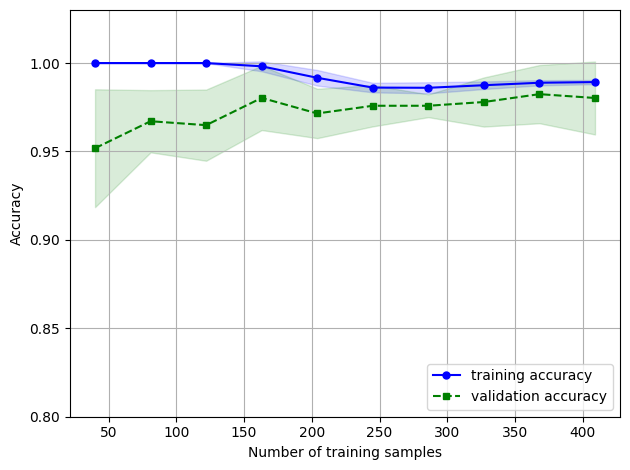

In [ ]:
### learning_curve 함수를 통해서 학습 곡선 그려보기

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='liblinear', 
                                           penalty='l2', 
                                           random_state=1))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

# 결과값을 보면 샘플이 적을땐 training set과 validation set의 score가 벌어져있는걸로 보아 오버피팅 문제가 있고,
# 샘플이 250개 정도부터 training set과 validation set의 score 오차가 많이 줄어들면서 제대로 모델이 동작하고 있는걸 알 수 있음. 

In [ ]:
### 그리드 서치를 이용해보자

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

# 파라미터의 범위를 정해주고, 그 범위들을 그리드서치 클래스가 전부 테스트해보고 제일 최적의 값을 찾아줌
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'svc__C': param_range,
     'svc__kernel': ['linear']},
    {'svc__C': param_range,
     'svc__kernel': ['rbf'],
     'svc__gamma': param_range}
]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10, n_jobs=1)

gs = gs.fit(X_train, y_train)
# 학습 결과는 그리드 서치의 속성에 들어가있어서 호출해서 출력 해볼 수 있음.
print(gs.best_params_, gs.best_estimator_)

## 그리드서치는 모든 하이퍼파라미터 조합에 대해서 전부 해보는데, k겹 교차검증까지 하기 때문에 시간 복잡도가 굉장히 큼
## 그래서 사이킷런에선 "랜덤서치" 클래스를 제공하고, 모든 하이퍼파라미터 조합에 대해 해보진 않고, 몇개만 랜덤으로 샘플링 해서 시도해봄
## 그 후 그리드 서치와 같이 결과를 클래스 속성에 넣어둠.

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'} Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100.0, gamma=0.001, random_state=1))])


In [ ]:
### 중첩 교차 검증을 통해서 알고리즘 선택하기
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  scoring='accuracy', cv=2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)

### 중첩 교차검증을 통해 support vector classifier는 정확도가 평균 0.974란걸 얻었고,
print("정확도: %.3f" % np.mean(scores))


### 한번 decision tree와 비교를 해보자면,
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

### 이 데이터셋에서는 support vector classifier가 더 좋다는걸 알 수 있다.
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print("정확도: %.3f" % np.mean(scores))

정확도: 0.974
정확도: 0.934


[[71  1]
 [ 2 40]]


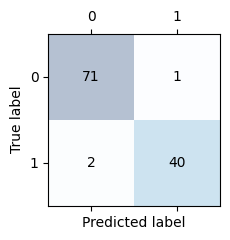

In [ ]:
### 오차행렬 구현해보기

from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)

y_pred = pipe_svc.predict(X_test)

# 사이킷런에는 confusion matrix를 불러올 수 있는 함수가 존재함.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

print(confmat)


fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

# 차례대로 true neg / false posi
#         false neg / true posi 임

In [ ]:
### 사이킷런에 구현되어있는 여러가지 평가 지표
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print(precision_score(y_true=y_test, y_pred=y_pred))
print(recall_score(y_true=y_test, y_pred=y_pred))
print(f1_score(y_true=y_test, y_pred=y_pred))

### 이 중에서 f1 score는 불균형 클래스에서 평가지표로 괜찮음.

# 예를 들어 양성이 매우 많고 음성이 적은 데이터셋에서 양성으로만 다 예측해도 정확도가 매우 높으니 사실상 정확도 지표는 의미가 없어질수도있음.
# 그래서 PRE와 REC을 조합한 F1 Score를 사용해서 음성을 못맞춘다면 점수가 많이 떨어지게 설계해놔서
# 불균형 클래스에서 학습 방향을 잡아줄 수 있음.

0.975609756097561
0.9523809523809523
0.963855421686747


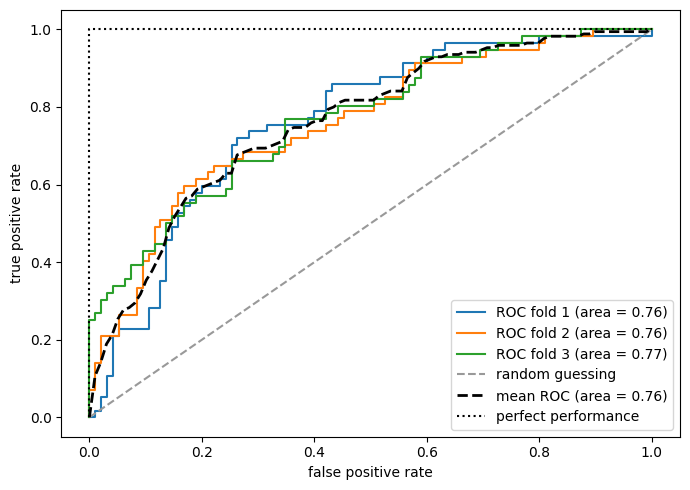

In [ ]:
### ROC 곡선 그리기

from sklearn.metrics import roc_curve, auc
from numpy import interp

# 앞에서 만들던대로 스케일링 -> 데이터 압축 -> 모델 학습 순으로 진행하는 파이프라인 만들어주고
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='liblinear',
                                           penalty='l2', 
                                           random_state=1, 
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    
# K겹 교차검증으로 만들어지는 각 교차 샘플들을 그려보면,
cv = list(StratifiedKFold(n_splits=3, shuffle=True,
                          random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

### 이런 결과를 얻을 수 있는데, 저 1이면 완벽한 추측, 0.5면 랜덤 추측 0.5이하면 반대로 추측하고 있다는 것으로 해석할 수 있음.
### 해당 폴드들은 0.5 ~ 1 사이니깐 준수하게 추론하고 있다고 볼 수 있음.

In [ ]:
### 불균형 클래스 다뤄보기

X_unb = np.vstack((X[ y == 0], X[ y == 1][:40]))
y_unb = np.vstack((y[ y == 0], y[ y == 1][:40]))